In [1]:
import os
import json
from pathlib import Path
from typing import Tuple, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image, UnidentifiedImageError

In [2]:
# The path that data has been saved is as follows:
Base_Path = "/sc/home/arman.beykmohammadi/coldstore/"

In [3]:
labels = pd.read_csv(os.path.join(
    "/sc/home/arman.beykmohammadi/coldstore/Retina/trainLabels.csv"))

In [4]:
labels

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1
...,...,...
35121,44347_right,0
35122,44348_left,0
35123,44348_right,0
35124,44349_left,0


In [5]:
import os
import pandas as pd
from PIL import Image, UnidentifiedImageError
from typing import Optional, Tuple
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split


class DiabeticRetinopathy(Dataset):
    """
    Dataset for diabetic retinopathy images and their labels.

    Parameters:
    base_path (str): The base path to the dataset directory.
    tfs (callable, optional): Transformations to be applied to the images.
    """

    def __init__(self, base_path: str, tfs: Optional[callable] = None):
        self.image_path = os.path.join(base_path, 'Retina', 'train')
        self.labels = pd.read_csv(os.path.join(
            base_path, 'Retina', 'trainLabels.csv'))
        self.tfs = tfs
        self._cached_dataset = None

    def cache_to_ram(self):
        if self._cached_dataset is None:
            _cached_dataset = []
            for i in range(len(self)):
                _cached_dataset.append(self._load_and_transform(i))
                print(f"Caching dataset: {i + 1}/{len(self)}", end="\r")
            self._cached_dataset = _cached_dataset

    def _load_and_transform(self, idx):
        img, label = self._load_item(idx)
        if self.tfs and img is not None:
            img = self.tfs(img)
        return img, label

    def __len__(self) -> int:
        return len(self.labels)

    def _load_item(self, idx: int) -> Tuple[Image.Image, int]:
        img_idx = self.labels.iloc[idx]['image']
        label = self.labels.iloc[idx]['level']
        try:
            img = Image.open(os.path.expanduser(
                os.path.join(self.image_path, img_idx + '.jpeg')))
        except (FileNotFoundError, UnidentifiedImageError) as e:
            print(f"Error loading image {img_idx}: {e}")
            return None, label
        return img, label

    def __getitem__(self, idx):
        if self._cached_dataset is not None:
            return self._cached_dataset[idx]
        return self._load_and_transform(idx)

In [ ]:
print(retina_dataset.labels['level'].value_counts())
(retina_dataset.labels[retina_dataset.labels['level'] != 0])

level
0    25810
2     5292
1     2443
3      873
4      708
Name: count, dtype: int64


,image,level
4,15_left,1
5,15_right,2
6,16_left,4
7,16_right,4
9,17_right,1
...,...,...
35098,44323_left,1
35099,44323_right,1
35105,44328_right,1
35112,44337_left,1


- Loading the pretariend model along with weights

- Extracting embeddings from the last layer on groups

- Checking statitical test to see if they are statistically different

- Uisng Grad-Cam for back-probabgating test-statistic and visualize differences

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.models import resnet50, ResNet50_Weights


HID_DIM = 2048
OUT_DIM = 128


# Resnet backbone
class resnet50_fext(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        if pretrained:
            backbone = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        else:
            backbone = resnet50(weights=None)
        self.encoder = nn.Sequential(*list(backbone.children())[:-1])

    def forward(self, x):
        embedding = self.encoder(x)
        embedding = embedding.view(embedding.size(0), -1)
        return embedding


# Linear model
class MLP(nn.Module):
    def __init__(self, in_dim, mlp_hid_size, proj_size):
        super().__init__()
        self.head = nn.Sequential(nn.Linear(in_dim, mlp_hid_size),
                                  nn.BatchNorm1d(mlp_hid_size),
                                  nn.ReLU(),
                                  nn.Linear(mlp_hid_size, proj_size))

    def forward(self, x):
        x = self.head(x)
        return (x)


# Byol model
class BYOL(nn.Module):
    def __init__(self, net, backbone, hid_dim, out_dim):
        super().__init__()
        self.net = net
        self.encoder = nn.Sequential(*list(backbone.children())[:-1])
        self.projection = MLP(in_dim=backbone.fc.in_features,
                              mlp_hid_size=hid_dim, proj_size=out_dim)
        self.prediction = MLP(
            in_dim=out_dim, mlp_hid_size=hid_dim, proj_size=out_dim)

    def forward(self, x):
        embedding = self.encoder(x)
        embedding = embedding.view(embedding.size()[0], -1)
        project = self.projection(embedding)

        if self.net == 'target':
            return (project)
        predict = self.prediction(project)
        return (predict)


# SimCLR model
class SimCLR(nn.Module):
    def __init__(self, backbone, hid_dim, out_dim):
        super(SimCLR, self).__init__()
        # we get representations from avg_pooling layer
        self.encoder = torch.nn.Sequential(*list(backbone.children())[:-1])
        self.projection = MLP(in_dim=backbone.fc.in_features,
                              mlp_hid_size=hid_dim, proj_size=out_dim)

    def forward(self, x):
        embedding = self.encoder(x)
        embedding = embedding.view(embedding.size()[0], -1)
        project = self.projection(embedding)
        return (project)

In [7]:
# Check if CUDA is available
if torch.cuda.is_available():
    num_devices = torch.cuda.device_count()
    print(f"Number of available CUDA devices: {num_devices}")

    for i in range(num_devices):
        print(f"Device {i}: {torch.cuda.get_device_name(i)}")
else:
    print("CUDA is not available on this system.")

Number of available CUDA devices: 8
Device 0: NVIDIA A40
Device 1: NVIDIA A40
Device 2: NVIDIA A40
Device 3: NVIDIA A40
Device 4: NVIDIA A40
Device 5: NVIDIA A40
Device 6: NVIDIA A40
Device 7: NVIDIA A40


In [8]:
from torchvision import transforms


def stratified_sampledataset(dataset: DiabeticRetinopathy, healthy_size: int, unhealthy_size: int, rnd_st: int = 42) -> Tuple[pd.DataFrame, pd.DataFrame]:
    # Separate healthy samples (class 0)
    healthy_samples = dataset.labels[dataset.labels['level'] == 0]
    healthy_sampled = healthy_samples.sample(
        n=healthy_size, random_state=rnd_st).reset_index(drop=True)

    # Separate unhealthy samples (classes 1-4)
    unhealthy_samples = dataset.labels[dataset.labels['level'].isin([
                                                                    1, 2, 3, 4])]

    # Determine total counts for stratified sampling
    total_unhealthy = unhealthy_samples['level'].value_counts()
    total_samples = unhealthy_size

    # Calculate the proportion of samples for each class => A series
    proportions = (total_unhealthy / total_unhealthy.sum()) * total_samples
    proportions = proportions.round().astype(int)  # Round to get integer counts

    unhealthy_sampled = []
    for label, count in proportions.items():
        if count > 0:  # Ensure we only sample if there are available samples
            class_samples = unhealthy_samples[unhealthy_samples['level'] == label]
            # it samples n rows from the rows of dataframe
            sampled_class = class_samples.sample(n=count, random_state=rnd_st)
            unhealthy_sampled.append(sampled_class)

    unhealthy_sampled_df = pd.concat(unhealthy_sampled).reset_index(drop=True)
    return healthy_sampled, unhealthy_sampled_df


class SampledDiabeticRetinopathy(Dataset):
    def __init__(self, dataframe: pd.DataFrame, base_path: str, tfs: Optional[callable] = None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.base_path = base_path
        self.tfs = tfs

    def __len__(self) -> int:
        return len(self.dataframe)

    def __getitem__(self, idx: int) -> Tuple[Image.Image, int]:
        img_idx = self.dataframe.iloc[idx]['image']
        label = self.dataframe.iloc[idx]['level']
        img = Image.open(os.path.join(
            self.base_path, 'Retina', 'train', img_idx + '.jpeg'))
        if self.tfs:
            img = self.tfs(img)
        return img, label


def get_tfms(size: int = 224, interpolation=Image.BILINEAR) -> transforms.Compose:
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    norm = transforms.Normalize(mean=mean, std=std)
    trsf = transforms.Compose([
        transforms.Resize(size=(size, size)),
        transforms.ToTensor(),
        norm,
    ])
    return trsf


with open('./src/config.json', 'r') as config_file:
    config = json.load(config_file)


def get_groups(config: dict = config) -> Tuple[SampledDiabeticRetinopathy, SampledDiabeticRetinopathy]:
    """
    Groups from diabetic retinopathy healthy(class=0) and unhealthy(class=1..4).

    Parameters:
    config (dict): A dictionary containing the parameters.
    """

    base_path = Path(config['base_path'])
    healthy_size = config['sample_size']['healthy_size']
    unhealthy_size = config['sample_size']['unhealthy_size']
    random_state = config['random_state']
    size = config['size']

    full_dataset = DiabeticRetinopathy(
        base_path=base_path, tfs=get_tfms(size=size))
    healthy, unhealthy = stratified_sampledataset(
        full_dataset, healthy_size, unhealthy_size, rnd_st=random_state)

    healthy_ds = SampledDiabeticRetinopathy(
        healthy, base_path=base_path, tfs=get_tfms())
    unhealthy_ds = SampledDiabeticRetinopathy(
        unhealthy, base_path=base_path, tfs=get_tfms())

    return (healthy_ds, unhealthy_ds)

In [ ]:
from tqdm import tqdm


def produce_and_save_embeddings_with_graph(config,
                                           checkpoint_path: str,
                                           output_path: str,
                                           batch_size: int = 32,
                                           device: torch.device = None):
    """
    Loads a pretrained SimCLR model and produces embeddings for both healthy
    and unhealthy retina samples, then saves them in a single HDF5 file with two datasets.

    Args:
        config (dict): Configuration dictionary containing base_path, sample sizes, random_state, size.
        checkpoint_path (str): Path to the SimCLR checkpoint (.pt) containing 'model' weights.
        output_path (str): Path where the output file will be created.
        batch_size (int): Batch size for DataLoader.
        device (torch.device): torch.device('cuda' or 'cpu'). If None, auto-select.
    """

    # 1. Device setup
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # 2. Instantiate SimCLR model and load weights
    backbone = resnet50(weights=None)
    model = SimCLR(backbone, hid_dim=2048, out_dim=128).to(device)
    ckpt = torch.load(checkpoint_path, map_location=device, weights_only=False)
    model.load_state_dict(ckpt['model'])
    model.eval()

    # 3. Prepare datasets
    healthy_ds, unhealthy_ds = get_groups(config)

    embeddings = {}

    for name, ds in [('healthy', healthy_ds), ('unhealthy', unhealthy_ds)]:
        loader = DataLoader(ds, batch_size=batch_size,
                            shuffle=False, num_workers=4, pin_memory=True)
        all_embeddings = []
        for xb, _ in tqdm(loader, desc=f"Processing {name}", unit="batch"):
            xb = xb.to(device)
            emb = model(xb)
            emb = emb.view(emb.size(0), -1)
            all_embeddings.append(emb)
        embeddings[name] = torch.cat(all_embeddings, dim=0)

    torch.save(embeddings, output_path)
    print(f"Saved embeddings to {output_path}")


os.makedirs("./embeddings_fine_tune", exist_ok=True)
produce_and_save_embeddings_with_graph(config,
                                       checkpoint_path='./simclr_finetuned_encoder_7',
                                       hdf5_path='./embeddings_fine_tune/retina_embeddings.h5',
                                       batch_size=128)

In [ ]:
import numpy as np
from torch.utils.data import Subset

# Get the indices into the underlying dataset
orig_indices = embed_dataset.indices
# Access the underlying dataset
underlying_dataset = embed_dataset.dataset

# Get labels for each sample in the Subset
labels = [underlying_dataset[i][1] for i in orig_indices]

# Find indices (relative to orig_indices) for each label
idx0 = [i for i, l in enumerate(labels) if l == 0]
idx1 = [i for i, l in enumerate(labels) if l == 1]
min_count = min(len(idx0), len(idx1))

np.random.seed(42)
idx0_sampled = np.random.choice(idx0, min_count, replace=False)
idx1_sampled = np.random.choice(idx1, min_count, replace=False)

# Create two new Subsets of embed_dataset (indices are relative to embed_dataset)
healthy_subset = Subset(embed_dataset, idx0_sampled)
unhealthy_subset = Subset(embed_dataset, idx1_sampled)

In [59]:
model

SimCLR(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 2

In [72]:
import os


def get_last_resnet_embeddings(model, healthy_ds, unhealthy_ds, device, output_path):
    embeddings = {}

    model.eval()
    for name, ds in [('healthy', healthy_ds), ('unhealthy', unhealthy_ds)]:
        loader = DataLoader(ds, batch_size=64,
                            shuffle=False, num_workers=4, pin_memory=True)
        embedding = []
        all_embeddings = []
        with torch.no_grad():
            for xb, _ in tqdm(loader, desc=f"Processing {name}", unit="batch"):
                xb = xb.to(device)
                enc = model.encoder(xb)
                enc = enc.view(enc.size(0), -1)  # shape is [batch, 2048]
                # emb = model.projection(enc)
                # emb = emb.view(emb.size(0), -1)
                all_embeddings.append(enc.cpu())
        embeddings[name] = torch.cat(all_embeddings, dim=0)

    # Ensure the directory exists
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    torch.save(embeddings, output_path)
    print(f"Saved embeddings to {output_path}")


embeddings = get_last_resnet_embeddings(
    model, healthy_subset, unhealthy_subset, device, output_path='./embeddings_fine_tune/retina_embeddings_resnet.h5')

Processing unhealthy: 100%|██████████| 110/110 [00:09<00:00, 11.61batch/s]


Saved embeddings to ./embeddings_fine_tune/retina_embeddings_resnet.h5


In [76]:
embeddings = torch.load('./embeddings_fine_tune/retina_embeddings_resnet.h5')
embeddings.keys()

dict_keys(['healthy', 'unhealthy'])

In [77]:
for key, value in embeddings.items():
    print(value.shape)

torch.Size([6987, 2048])
torch.Size([6987, 2048])


In [63]:
class MMDTest:
    def __init__(self, features_X, features_Y, n_perm=1000):

        self.n_perm = n_perm
        self.features_X = features_X
        self.features_Y = features_Y

    def _compute_mmd(self, features_X, features_Y):

        mean_fX = features_X.mean(0)
        mean_fY = features_Y.mean(0)
        D = mean_fX - mean_fY
        statistic = np.linalg.norm(D)**2
        return statistic

    def _compute_p_value(self):

        # compute real test statistic
        stat = self._compute_mmd(self.features_X, self.features_Y)
        n, m = len(self.features_X), len(self.features_Y)
        l = n + m
        features_Z = np.vstack((self.features_X, self.features_Y))

        # compute null samples
        resampled_vals = np.empty(self.n_perm)
        for i in range(self.n_perm):
            index = np.random.permutation(l)  # it permutes indices from 0 to l
            feats_X, feats_Y = features_Z[index[:n]], features_Z[index[n:]]
            resampled_vals[i] = self._compute_mmd(feats_X, feats_Y)

        resampled_vals.sort()
        # p_val = np.mean(stat < resampled_vals)
        p_val = (np.sum(stat <= resampled_vals)+1)/(self.n_perm+1)
        return p_val

    def test(self):
        return (self._compute_p_value())

In [64]:
emb_gr1 = embeddings["healthy"].detach().numpy()
emb_gr2 = embeddings["unhealthy"].detach().numpy()
mmd = MMDTest(emb_gr1, emb_gr2, n_perm=1000)
p_val = mmd.test()
print(f"P-value from MMDTest: {p_val}")

P-value from MMDTest: 0.000999000999000999


# Fine Tuning on Retina

In [10]:
import os
import json
import pandas as pd
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split


def stratified_split_indices(labels, test_size=0.75, random_state=42):
    indices = list(range(len(labels)))
    train_idx, test_idx = train_test_split(
        indices,
        test_size=test_size,
        stratify=labels,
        random_state=random_state
    )
    return train_idx, test_idx


with open('./src/config.json', 'r') as config_file:
    config = json.load(config_file)

base_path = config['base_path']
size = config.get('size', 224)
finetune_frac = 0.25
batch_size = config.get('batch_size', 64)
random_state = config.get('random_state', 42)

dataset = DiabeticRetinopathy(base_path, tfs=get_tfms(size=size))

# Stratified split: 25% fine-tuning, 75% embedding
labels = dataset.labels['level'].values
finetune_idx, embed_idx = stratified_split_indices(labels, test_size=0.75)

finetune_dataset = Subset(dataset, finetune_idx)
embed_dataset = Subset(dataset, embed_idx)

# Cache both splits
print("Caching fine-tuning data to RAM...")
_ = [finetune_dataset.dataset.cache_to_ram()]
print("Caching embedding data to RAM...")
_ = [embed_dataset.dataset.cache_to_ram()]

# Dataloaders
finetune_loader = DataLoader(
    finetune_dataset, batch_size=batch_size, shuffle=True)
embed_loader = DataLoader(embed_dataset, batch_size=batch_size, shuffle=False)

Caching fine-tuning data to RAM...
Caching embedding data to RAM...


In [12]:
j = 0
for i in range(len(dataset)):
    if dataset[i][1] not in [0, 1]:
        print(i)
        j += 1
        if j > 10:
            break

5
6
7
23
30
42
46
47
78
79
80


In [13]:
for i in range(len(dataset._cached_dataset)):
    img, label = dataset._cached_dataset[i]
    binary_label = 0 if label == 0 else 1
    dataset._cached_dataset[i] = (img, binary_label)

In [14]:
j = 0
for i in range(len(dataset)):
    if dataset[i][1] not in [0, 1]:
        print(i)
        j += 1
        if j > 10:
            break

In [ ]:
for i in range(len(finetune_dataset)):
    if finetune_dataset[i][1] not in [0, 1]:
        print(i)

In [25]:
dataset.labels['level']

0        0
1        0
2        0
3        0
4        1
        ..
35121    0
35122    0
35123    0
35124    0
35125    1
Name: level, Length: 35126, dtype: int64

In [ ]:
dataset.labels['level'] = dataset.labels['level'].apply(
    lambda x: 0 if x == 0 else 1)

In [26]:
finetune_dataset.dataset.labels

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1
...,...,...
35121,44347_right,0
35122,44348_left,0
35123,44348_right,0
35124,44349_left,0


In [27]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.models import resnet50
from tqdm import tqdm

# Load pre-trained SimCLR backbone & projection
backbone = resnet50(weights=None)
model = SimCLR(backbone, hid_dim=2048, out_dim=128)
model.load_state_dict(torch.load(
    './2_last_sclr.pt', map_location="cpu", weights_only=False)['model'])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Unfreeze projection head and last block of encoder
for param in model.parameters():
    param.requires_grad = False
for param in model.projection.parameters():
    param.requires_grad = True
for param in model.encoder[7].parameters():  # Unfreeze last ResNet block
    param.requires_grad = True

# Add classifier head for binary classification
model.classifier = nn.Linear(128, 1).to(device)
for param in model.classifier.parameters():
    param.requires_grad = True

# Optimizer and loss
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()

# Training loop
epochs = 10
model.train()
for epoch in range(epochs):
    total_loss = 0
    for imgs, labels in tqdm(finetune_loader, desc=f"Epoch {epoch+1}"):
        imgs = imgs.to(device)
        labels = labels.float().to(device).unsqueeze(1)
        optimizer.zero_grad()
        with torch.set_grad_enabled(True):
            features = model(imgs)
            logits = model.classifier(features)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
    print(f"Epoch {epoch+1}: Loss {total_loss/len(finetune_loader):.4f}")

# Save fine-tuned model
torch.save({'model': model.state_dict()}, "simclr_finetuned_encoder_7.pt")

Epoch 1: 100%|██████████| 138/138 [00:18<00:00,  7.66it/s]


Epoch 1: Loss 0.5799


Epoch 2: 100%|██████████| 138/138 [00:16<00:00,  8.43it/s]


Epoch 2: Loss 0.4747


Epoch 3: 100%|██████████| 138/138 [00:15<00:00,  8.64it/s]


Epoch 3: Loss 0.4160


Epoch 4: 100%|██████████| 138/138 [00:17<00:00,  7.92it/s]


Epoch 4: Loss 0.3291


Epoch 5: 100%|██████████| 138/138 [00:16<00:00,  8.57it/s]


Epoch 5: Loss 0.1940


Epoch 6: 100%|██████████| 138/138 [00:16<00:00,  8.52it/s]


Epoch 6: Loss 0.0766


Epoch 7: 100%|██████████| 138/138 [00:17<00:00,  7.68it/s]


Epoch 7: Loss 0.0313


Epoch 8: 100%|██████████| 138/138 [00:16<00:00,  8.57it/s]


Epoch 8: Loss 0.0175


Epoch 9: 100%|██████████| 138/138 [00:16<00:00,  8.46it/s]


Epoch 9: Loss 0.0175


Epoch 10: 100%|██████████| 138/138 [00:16<00:00,  8.59it/s]


Epoch 10: Loss 0.0085


In [28]:
model

SimCLR(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 2

# gradcam

- They are statistically different

- Now let's backpropagate the test-statistics to see what we can visualize

- Lets also look at p-value for smaller number of samples

In [78]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size,
                              padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Average pooling across channels
        avg_out = torch.mean(x, dim=1, keepdim=True)
        # Max pooling across channels
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        # Concatenate both maps
        attention = torch.cat([avg_out, max_out], dim=1)
        attention = self.conv(attention)  # Apply convolution
        return self.sigmoid(attention)  # Apply sigmoid to get attention scores


class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.fc1 = nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False)
        self.fc2 = nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = F.adaptive_avg_pool2d(x, 1)
        max_out = F.adaptive_max_pool2d(x, 1)
        avg_out = self.fc1(avg_out)
        max_out = self.fc1(max_out)
        out = self.fc2(avg_out + max_out)
        return self.sigmoid(out)

# Mean of Embeddings
- I can compute mean of embeddings as follows:

In [79]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict


class ProbBase(object):
    def __init__(self, model, target_layer, relu, device, attention=None):
        self.model = model
        self.device = device
        self.relu = relu
        self.attention = SpatialAttention().to(self.device) if attention == 'spatial' else (
            ChannelAttention().to(self.device) if attention == 'channel' else None)
        self.model.to(self.device)
        self.model.eval()
        self.target_layer = target_layer
        self.outputs_backward = OrderedDict()
        self.outputs_forward = OrderedDict()
        self.set_hook_func()

    def set_hook_func(self):
        raise NotImplementedError

    def forward(self, x):
        self.image_size = x.size(-1)
        self.embed = self.model(x)
        return self.embed

    def backward(self, statistic):
        self.model.zero_grad()
        self.statistic = statistic.to(self.device)
        # print("Before backward, test statistic grad_fn:", self.statistic.grad_fn)
        self.statistic.backward(retain_graph=True)
        # checking if gradients are computed for parameters
        # for name, param in self.model.named_parameters():
        # if param.grad is not None:
        # print(f"Gradient for {name} after backward pass exists.")
        # else:
        # print(f"No gradient computed for {name}")

    def get_conv_outputs(self, outputs, target_layer):
        for key, value in outputs.items():
            for module in self.model.named_modules():
                if id(module[1]) == key:
                    if module[0] == target_layer:
                        return value
        raise ValueError(f'Invalid layer name: {target_layer}')


class GradCAM(ProbBase):
    def set_hook_func(self):
        def func_b(module, grad_in, grad_out):
            self.outputs_backward[id(module)] = grad_out[0].cpu()
        # print(f'outputs_backward:{self.outputs_backward.values()}\n')

        def func_f(module, input, f_output):
            self.outputs_forward[id(module)] = f_output
        # print(f'outputs_forward:{self.outputs_forward.values()}\n')

        for module in self.model.named_modules():
            if module[0] == self.target_layer:
                # saves output of backward pass
                module[1].register_backward_hook(func_b)
                # saves output of forward pass
                module[1].register_forward_hook(func_f)

    def normalize(self, grads):
        l2_norm = torch.sqrt(torch.mean(torch.pow(grads, 2))) + 1e-5
        return grads / l2_norm.item()

    def compute_gradient_weights(self):
        self.grads = self.normalize(self.grads.squeeze())
        self.map_size = self.grads.size()[2:]
        self.alpha = nn.AvgPool2d(self.map_size)(self.grads)

    def generate(self):
        # shape:torch tensor [128, 64, 16, 16]
        self.grads = self.get_conv_outputs(
            self.outputs_backward, self.target_layer)
        # print(f'\nGetting gradient in generate:{self.grads.shape}')

        # compute weithts based on the gradient:a_{k}^{c} = GAP(d(dmmd)/d(A_{ij}^{k}))
        # get alpha=weights: torch_tensor:([128, 64, 1, 1]),torch.float32
        # New value for DR: [16, 2048, 1, 1]
        self.compute_gradient_weights()
        # print(f'\nComputing coefficients alpha using GAP:{self.alpha.shape},{self.alpha.dtype}')

        # get activation A_k
        # shape:torch tensor [128, 64, 16, 16]
        # New value for DR: torch.Size([16, 2048, 7, 7]
        self.activation = self.get_conv_outputs(
            self.outputs_forward, self.target_layer)
        # print(f'\nShape and type activateions A_k:{self.activation.shape},{self.activation.dtype}')
        # let's see if attention helps rfinement
        if self.attention:
            # print('attention was applied')
            attention_weights = self.attention(self.activation)
            self.activation = self.activation * attention_weights

        self.activation = self.activation[None, :, :, :, :]
        self.alpha = self.alpha[:, None, :, :, :]

        # print(f'act:{self.activation.shape}')
        # print(f'alpha:{self.alpha.shape}')

        # gcam: torch.Size([1, 128, 1, 16, 16]), torch.float32
        # in original paper we have ReLU, but we dot have it here
        # L_{gcam}^{c} = ReLU(sum_{a_{k}A_{k}})
        # New val:
        gcam = F.conv3d(self.activation, (self.alpha.cuda()),
                        padding=0, groups=len(self.alpha))
        # print(f'\nShape of heatmap after mul alpha_kxA_k:{gcam.shape},{gcam.dtype}')

        # gcam size: [128, 1, 16, 16]
        gcam = gcam.squeeze(dim=0)
        # print(f'\ngcam size:{gcam.size()}')
        # Upsample gcam to the size of image: [128, 1, 64, 64]
        gcam = F.interpolate(
            gcam, (self.image_size, self.image_size), mode="bilinear")
        # print(f'\nsize of heatmap after upsampling:{gcam.size()}')
        # gcam size: [128, 1, 64, 64]
        # applying relue to produce features that positively impact test statistic
        if self.relu:
            gcam = F.relu(gcam)
            # print('ReLU was applied!')
        else:
            gcam = torch.abs(gcam)
        # print(f'\nsize of heatmap after abs value:{gcam.size()}')
        return gcam

### Changes in the code:

 - **First**: 
 
    - compute embeddings for the first group and save them => **$\mu_{1}$**
    - compute embeddings for the second group and save them => **$\mu_{2}$**
 - **Second**:
 
   - Load saved embeddings 
   
   - For each batch, compute emebdding in forward pass and compute => **$\mu_{1}' = \mu_{1} - d_{i}+d_{i}$**, where $d_{i}$ is the embedding of i-th batch.

   - Compute test-statistic **$S$**
   
   - Backprobagate test-statistic **$S$** to get heatmaps
 

In [68]:
for name, _ in model.named_modules():
    print(name)


encoder
encoder.0
encoder.1
encoder.2
encoder.3
encoder.4
encoder.4.0
encoder.4.0.conv1
encoder.4.0.bn1
encoder.4.0.conv2
encoder.4.0.bn2
encoder.4.0.conv3
encoder.4.0.bn3
encoder.4.0.relu
encoder.4.0.downsample
encoder.4.0.downsample.0
encoder.4.0.downsample.1
encoder.4.1
encoder.4.1.conv1
encoder.4.1.bn1
encoder.4.1.conv2
encoder.4.1.bn2
encoder.4.1.conv3
encoder.4.1.bn3
encoder.4.1.relu
encoder.4.2
encoder.4.2.conv1
encoder.4.2.bn1
encoder.4.2.conv2
encoder.4.2.bn2
encoder.4.2.conv3
encoder.4.2.bn3
encoder.4.2.relu
encoder.5
encoder.5.0
encoder.5.0.conv1
encoder.5.0.bn1
encoder.5.0.conv2
encoder.5.0.bn2
encoder.5.0.conv3
encoder.5.0.bn3
encoder.5.0.relu
encoder.5.0.downsample
encoder.5.0.downsample.0
encoder.5.0.downsample.1
encoder.5.1
encoder.5.1.conv1
encoder.5.1.bn1
encoder.5.1.conv2
encoder.5.1.bn2
encoder.5.1.conv3
encoder.5.1.bn3
encoder.5.1.relu
encoder.5.2
encoder.5.2.conv1
encoder.5.2.bn1
encoder.5.2.conv2
encoder.5.2.bn2
encoder.5.2.conv3
encoder.5.2.bn3
encoder.5.2.relu

In [ ]:
# change of batch size can be a potential problem

def generate_heatmaps(gcam, emb_gr1, emb_gr2, loader1, loader2, device):
    heatmaps1, heatmaps2 = [], []
    sum1 = emb_gr1.sum(dim=0, keepdim=True).to(device)
    sum2 = emb_gr2.sum(dim=0, keepdim=True).to(device)
    N1, N2 = emb_gr1.shape[0], emb_gr2.shape[0]

    for idx, (imgs, _) in enumerate(tqdm(loader1, desc="Group 1", unit="batch")):
        imgs = imgs.to(device)
        d_new = gcam.forward(imgs).view(imgs.size(0), -1)
        start = idx * loader1.batch_size
        end = start + loader1.batch_size
        batch_old = emb_gr1[start:end].to(device)
        sum1_new = sum1 - \
            batch_old.sum(dim=0, keepdim=True) + d_new.sum(dim=0, keepdim=True)
        mu1_new = sum1_new / N1
        mu2 = sum2 / N2
        S = torch.norm(mu1_new - mu2, p=2)
        gcam.backward(S)
        hm = gcam.generate().squeeze(1).detach().cpu().numpy()
        heatmaps1.append(hm)

    for idx, (imgs, _) in enumerate(tqdm(loader2, desc="Group 2", unit="batch")):
        imgs = imgs.to(device)
        d_new = gcam.forward(imgs).view(imgs.size(0), -1)
        start = idx * loader2.batch_size
        end = start + imgs.size(0)
        batch_old = emb_gr2[start:end].to(device)
        sum2_new = sum2 - \
            batch_old.sum(dim=0, keepdim=True) + d_new.sum(dim=0, keepdim=True)
        mu2_new = sum2_new / N2
        mu1 = sum1 / N1
        S = torch.norm(mu1 - mu2_new, p=2)
        gcam.backward(S)
        hm = gcam.generate().squeeze(1).detach().cpu().numpy()
        heatmaps2.append(hm)

    return np.concatenate(heatmaps1, axis=0), np.concatenate(heatmaps2, axis=0)


gcam = GradCAM(model, target_layer="encoder.7", relu=True, device=device)

loader1 = DataLoader(healthy_subset, batch_size=64, shuffle=False)
loader2 = DataLoader(unhealthy_subset, batch_size=64, shuffle=False)

emb = torch.load('./embeddings_fine_tune/retina_embeddings_resnet.h5',
                 map_location="cpu")

emb1, emb2 = emb["healthy"], emb["unhealthy"]

heat1, heat2 = generate_heatmaps(gcam, emb1, emb2, loader1, loader2, device)

Group 1:   0%|          | 0/110 [00:00<?, ?batch/s]

Group 1:   0%|          | 0/110 [00:00<?, ?batch/s]


RuntimeError: The size of tensor a (2048) must match the size of tensor b (128) at non-singleton dimension 1

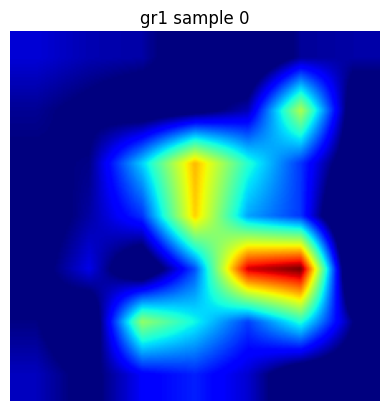

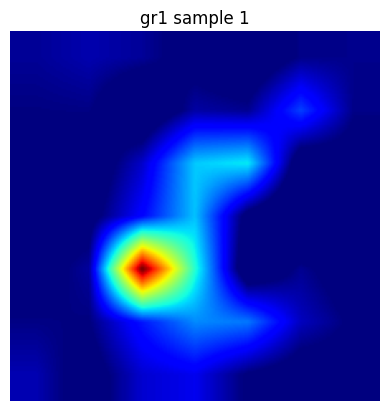

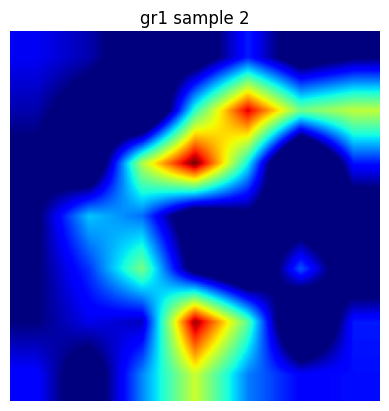

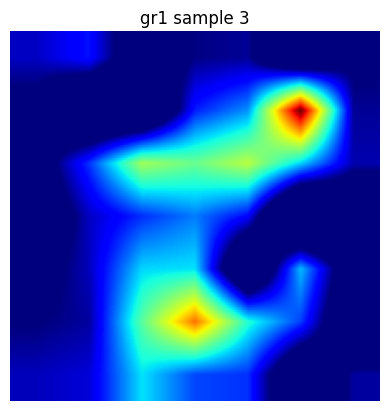

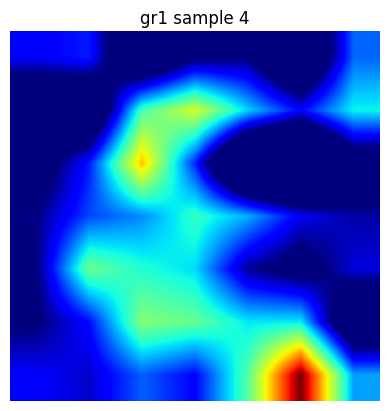

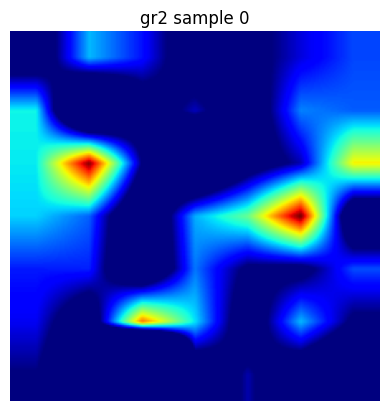

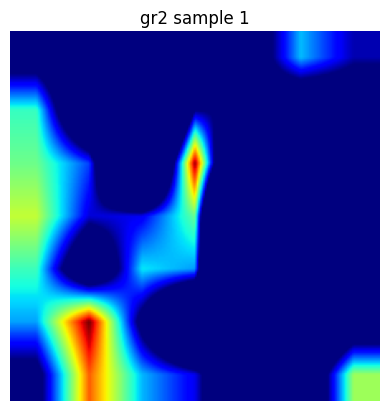

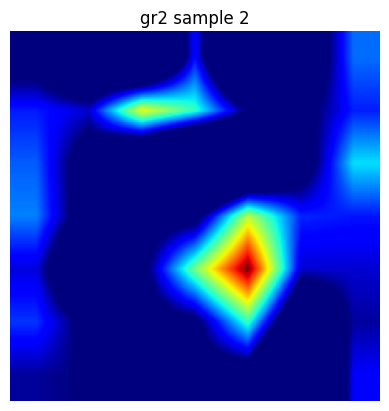

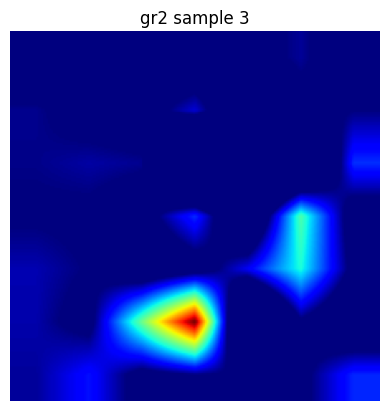

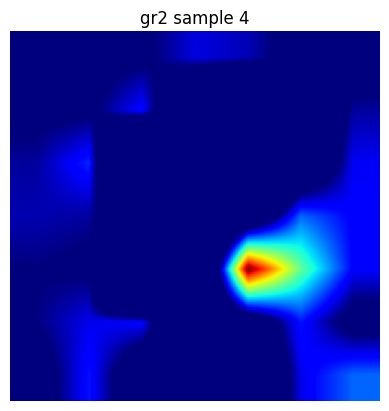

In [70]:
import matplotlib.pyplot as plt
import os
import numpy as np


def visualize_and_save_heatmaps(heatmaps, output_dir, prefix="gr", image_size=224, n_show=5):
    os.makedirs(output_dir, exist_ok=True)
    for i, hm in enumerate(heatmaps):
        # Save as image
        plt.imsave(os.path.join(
            output_dir, f"{prefix}_heatmap_{i}.png"), hm, cmap='jet')

        # Optionally display the first few
        if i < n_show:
            plt.imshow(hm, cmap='jet')
            plt.title(f"{prefix} sample {i}")
            plt.axis("off")
            plt.show()


visualize_and_save_heatmaps(heat1, "./heatmaps/group1", prefix="gr1")
visualize_and_save_heatmaps(heat2, "./heatmaps/group2", prefix="gr2")

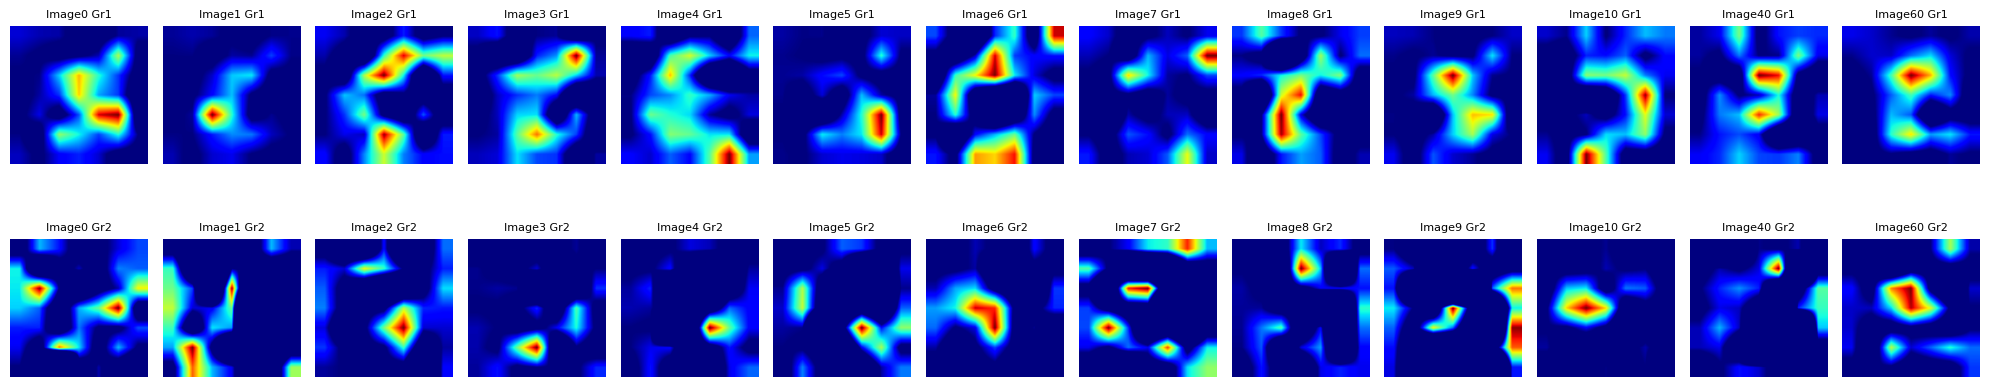

In [71]:
def visualize_heatmaps_grid(group1_dir, group2_dir, indices=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 40, 60], figsize=(20, 5)):
    fig, axes = plt.subplots(2, len(indices), figsize=figsize)

    for i, idx in enumerate(indices):
        # Load group 1 heatmap
        path1 = os.path.join(group1_dir, f"gr1_heatmap_{idx}.png")
        img1 = plt.imread(path1)
        axes[0, i].imshow(img1, cmap='viridis')
        axes[0, i].axis('off')
        axes[0, i].set_title(f"Image{idx} Gr1", fontsize=8)

        # Load group 2 heatmap
        path2 = os.path.join(group2_dir, f"gr2_heatmap_{idx}.png")
        img2 = plt.imread(path2)
        axes[1, i].imshow(img2, cmap='viridis')
        axes[1, i].axis('off')
        axes[1, i].set_title(f"Image{idx} Gr2", fontsize=8)

    plt.tight_layout()
    plt.show()


visualize_heatmaps_grid("./heatmaps/group1", "./heatmaps/group2")

In [ ]:
import matplotlib.pyplot as plt

# Grouping images
group1_images = [
    heat0_gr1, heat1_gr1, heat2_gr1, heat3_gr1, heat4_gr1,
    heat5_gr1, heat6_gr1, heat7_gr1, heat8_gr1, heat9_gr1,
    heat10_gr1, heat40_gr1, heat60_gr1
]

group2_images = [
    heat0_gr2, heat1_gr2, heat2_gr2, heat3_gr2, heat4_gr2,
    heat5_gr2, heat6_gr2, heat7_gr2, heat8_gr2, heat9_gr2,
    heat10_gr2, heat40_gr2, heat60_gr2
]

num_images = len(group1_images)  # Number of images per group

fig, axes = plt.subplots(nrows=2, ncols=num_images, figsize=(
    num_images * 2, 6))  # 2 rows, N columns

# Titles for each image
titles1 = [f"Image{i} Gr1" for i in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 40, 60]]

titles2 = [f"Image{i} Gr2" for i in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 40, 60]]

# Plot Group 1 in the first row
for i in range(num_images):
    axes[0, i].imshow(group1_images[i], cmap='viridis')
    axes[0, i].set_title(titles1[i])
    axes[0, i].axis('off')

# Plot Group 2 in the second row
for i in range(num_images):
    axes[1, i].imshow(group2_images[i], cmap='viridis')
    axes[1, i].set_title(titles2[i])
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

### Importing heatmaps and looking at them 

In [ ]:
import numpy as np

from PIL import Image

In [ ]:
class ZeroGradientError(Exception):
    """Custom exception to handle cases where the gradient is zero."""
    pass


def save_cam_with_alpha(image, gcam, alpha=0.5):

    # Convert grayscale image to 3 channels if needed
    if len(image.shape) == 2:  # Grayscale image (H, W)
        image = np.stack([image] * 3, axis=-1)  # Convert to (H, W, 3)

    # Normalize the Grad-CAM values to [0, 1]
    # Normalize the Grad-CAM values to [0, 1], handling zero gradients
    gcam_min = np.min(gcam)
    gcam_max = np.max(gcam)

    try:
        if gcam_max == gcam_min:  # If all values are zero, raise an error
            raise ZeroGradientError(
                "Gradient map contains only zero values, cannot overlay.")
        # Normalize gradient map
        gcam = (gcam - gcam_min) / (gcam_max - gcam_min)
    except ZeroGradientError as e:
        print(f"Error: {e}")
        # Handle the error (for example, return the original image or skip processing)
        return image, image  # Return the original image if error occurs

    # Resize Grad-CAM to match the image dimensions (224x224)
    # Get height and width (height, width) from image shape
    h, w = image.shape[:2]
    gcam_resized = np.array(Image.fromarray(
        gcam).resize((w, h), Image.BILINEAR))

    # Apply a colormap (similar to cv2.applyColorMap)
    # Apply colormap and select RGB channels
    gcam_colored = plt.cm.jet(gcam_resized)[:, :, :3] * 255
    gcam_colored = gcam_colored.astype(np.uint8)

    # Add Grad-CAM on top of the original image using alpha blending
    heatmap = gcam_colored.astype(np.float64)

    # checking dimension of image and heatmaps
    print(f'heatmap:{heatmap.shape}')
    print(f'image:{image.shape}')

    overlaid_image = (alpha * heatmap + (1 - alpha) *
                      image.astype(np.float64)).astype(np.uint8)

    return image, overlaid_image

In [ ]:
path1 = './adni_heatmaps/gr1.npy'

path2 = './adni_heatmaps/gr2.npy'

In [ ]:
heat1 = np.load(path1)

heat2 = np.load(path2)

In [ ]:
print(heat1.shape)

print(heat2.shape)

In [ ]:
import utils
import sys
import os

# Get the absolute path of the 'src' directory
src_path = os.path.abspath("src")

# Add 'src' to system path
if src_path not in sys.path:
    sys.path.append(src_path)

- To use functions from utils, we can do it as follows:

  - utils.save_cam_with_alpha(...)
  - utils.overlay_heatmap_single(...)

In [ ]:
gr0 = gr0_64

gr1 = gr1_64

In [ ]:
sing_img0 = gr0[0]

In [ ]:
sing_img0.shape

In [ ]:
plt.imshow(sing_img0)

In [ ]:
sing_img1 = gr1[0]

In [ ]:
sing_img1.shape

In [ ]:
plt.imshow(sing_img1)

In [ ]:
print(type(sing_img0))

print(type(sing_img1))

In [ ]:
print(sing_img0.dtype)

print(sing_img1.dtype)

In [ ]:
heat_img0_gr0 = heat1[0]

heat_img1_gr1 = heat2[0]

In [ ]:
img0_gr0, ov_im0_gr0 = save_cam_with_alpha(sing_img0, heat_img0_gr0, alpha=0.5)

img0_gr1, ov_im0_gr1 = save_cam_with_alpha(sing_img1, heat_img1_gr1, alpha=0.5)

### Heatmaps of group0 

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(img0_gr0)

plt.axis("off")

axes[1].imshow(ov_im0_gr0)

plt.axis("off")

### Heatmaps of group1

In [ ]:
img0_gr1, ov_im0_gr1

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(img0_gr1)

plt.axis("off")
axes[1].imshow(ov_im0_gr1)

plt.axis("off")

- Let's consider another image in the group

In [ ]:
img10_gr0 = gr0[10]

img10_gr1 = gr1[10]

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(img10_gr0)

axes[0].axis("off")

axes[1].imshow(img10_gr1)

axes[1].axis("off")

In [ ]:
heat10_gr0 = heat1[10]

heat10_gr1 = heat2[10]

In [ ]:
img10_gr0, ov_im10_gr0 = save_cam_with_alpha(img10_gr0, heat10_gr0, alpha=0.5)

img10_gr1, ov_im10_gr1 = save_cam_with_alpha(img10_gr1, heat10_gr1, alpha=0.5)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(img10_gr0)

plt.axis("off")

axes[1].imshow(ov_im10_gr0)

plt.axis("off")

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(img10_gr1)

plt.axis("off")

axes[1].imshow(ov_im10_gr1)

plt.axis("off")

- Let's look at image 40

In [ ]:
img40_gr0 = gr0[40]

img40_gr1 = gr1[40]

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(img40_gr0)

axes[0].axis("off")

axes[1].imshow(img40_gr1)

axes[1].axis("off")

In [ ]:
heat40_gr0 = heat1[40]

heat40_gr1 = heat2[40]

In [ ]:
img40_gr0, ov_im40_gr0 = save_cam_with_alpha(img40_gr0, heat40_gr0, alpha=0.5)

img40_gr1, ov_im40_gr1 = save_cam_with_alpha(img40_gr1, heat40_gr1, alpha=0.5)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(img40_gr0)

plt.axis("off")

axes[1].imshow(ov_im40_gr0)

plt.axis("off")

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(img40_gr1)

plt.axis("off")

axes[1].imshow(ov_im40_gr1)

plt.axis("off")

- Let's look at images 50 or 60

In [ ]:
img60_gr0 = gr0[60]

img60_gr1 = gr1[60]

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(img60_gr0)

axes[0].set_title('group 0')

axes[0].axis("off")

axes[1].imshow(img60_gr1)

axes[1].set_title('group 1')
axes[1].axis("off")

In [ ]:
heat60_gr0 = heat1[60]

heat60_gr1 = heat2[60]

In [ ]:
img60_gr0, ov_im60_gr0 = save_cam_with_alpha(img60_gr0, heat60_gr0, alpha=0.5)

img60_gr1, ov_im60_gr1 = save_cam_with_alpha(img60_gr1, heat60_gr1, alpha=0.5)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(img60_gr0)

plt.axis("off")

axes[1].imshow(ov_im60_gr0)

plt.axis("off")

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(img60_gr1)

axes[0].axis("off")

axes[1].imshow(ov_im60_gr1)

plt.axis("off")

- How to adjust alhos:

  - If you want precise attention to specific areas in the heatmap but don't want to lose the context of the original image (e.g., object recognition, localization), try alpha around 0.3 to 0.5.
  
  - Lets change alpha

In [ ]:
img60_gr0, ov_im60_gr0_3 = save_cam_with_alpha(
    img60_gr0, heat60_gr0, alpha=0.3)

img60_gr1, ov_im60_gr1_3 = save_cam_with_alpha(
    img60_gr1, heat60_gr1, alpha=0.3)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(img60_gr0)

axes[0].axis("off")

axes[1].imshow(ov_im60_gr0_3)

axes[1].axis("off")

In [ ]:
img60_gr0, ov_im60_gr0_4 = save_cam_with_alpha(
    img60_gr0, heat60_gr0, alpha=0.4)

img60_gr1, ov_im60_gr1_4 = save_cam_with_alpha(
    img60_gr1, heat60_gr1, alpha=0.4)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(img60_gr0)

axes[0].axis("off")

axes[1].imshow(ov_im60_gr0_4)

axes[1].axis("off")

- It seems $\alpha = 0.4$ works better for heatmap visualisation

## Checking modified code 

- Here, I changed the code such that we do not have to use whole samples for backprobagation

In [ ]:
# path to heatmaps after returning the normalisation to the previous type: /255.0

path1 = './adni_heatmaps/gr1_100_64_scd.npy'

path2 = './adni_heatmaps/gr2_100_64_scd.npy'

In [ ]:
gr1_heat = np.load(path1)

gr2_heat = np.load(path2)

In [ ]:
heat0_gr1 = gr1_heat[0]
heat0_gr2 = gr2_heat[0]

In [ ]:
group0_100 = group0[:100]
group1_100 = group1[:100]

In [ ]:
img0_gr1 = group0_100[0]
img0_gr2 = group1_100[0]

In [ ]:
img0_gr1, ov_img0_gr1 = save_cam_with_alpha(img0_gr1, heat0_gr1, alpha=0.5)

img0_gr2, ov_img0_gr2 = save_cam_with_alpha(img0_gr2, heat0_gr2, alpha=0.5)

### First group

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))

axes[0].imshow(img0_gr1)
axes[0].axis("off")
axes[0].set_title('Image0 group1')

axes[1].imshow(ov_img0_gr1)
axes[1].axis("off")
axes[1].set_title('Overlay Image0 group1')

axes[2].imshow(heat0_gr1)
axes[2].axis("off")
axes[2].set_title('Heatmap Image0 group1')

### Second group

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))

axes[0].imshow(img0_gr2)
axes[0].axis("off")
axes[0].set_title('Image0 group2')

axes[1].imshow(ov_img0_gr2)
axes[1].axis("off")
axes[1].set_title('Overlay Image0 group2')

axes[2].imshow(heat0_gr2)
axes[2].axis("off")
axes[2].set_title('Heatmap Image0 group2')

### First group => Image 10

In [ ]:
img10_gr1 = group0_100[10]
img10_gr2 = group1_100[10]

heat10_gr1 = gr1_heat[10]
heat10_gr2 = gr2_heat[10]

img10_gr1, ov_img10_gr1 = save_cam_with_alpha(img10_gr1, heat10_gr1, alpha=0.5)

img10_gr2, ov_img10_gr2 = save_cam_with_alpha(img10_gr2, heat10_gr2, alpha=0.5)

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))

axes[0].imshow(img10_gr1)
axes[0].axis("off")
axes[0].set_title('Image10 group1')

axes[1].imshow(ov_img10_gr1)
axes[1].axis("off")
axes[1].set_title('Overlay Image10 group1')

axes[2].imshow(heat10_gr1)
axes[2].axis("off")
axes[2].set_title('Heatmap Image10 group1')

### Second group => Image 10

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))

axes[0].imshow(img10_gr2)
axes[0].axis("off")
axes[0].set_title('Image10 group2')

axes[1].imshow(ov_img10_gr2)
axes[1].axis("off")
axes[1].set_title('Overlay Image10 group2')

axes[2].imshow(heat10_gr2)
axes[2].axis("off")
axes[2].set_title('Heatmap Image10 group2')

### First group => Image 40

In [ ]:
img40_gr1 = group0_100[40]
img40_gr2 = group1_100[40]

heat40_gr1 = gr1_heat[40]
heat40_gr2 = gr2_heat[40]

img40_gr1, ov_img40_gr1 = save_cam_with_alpha(img40_gr1, heat40_gr1, alpha=0.5)

img40_gr2, ov_img40_gr2 = save_cam_with_alpha(img40_gr2, heat40_gr2, alpha=0.5)

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))

axes[0].imshow(img40_gr1)
axes[0].axis("off")
axes[0].set_title('Image40 group1')

axes[1].imshow(ov_img40_gr1)
axes[1].axis("off")
axes[1].set_title('Overlay Image40 group1')

axes[2].imshow(heat40_gr1)
axes[2].axis("off")
axes[2].set_title('Heatmap Image40 group1')

### Second group => Image 40

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))

axes[0].imshow(img40_gr2)
axes[0].axis("off")
axes[0].set_title('Image40 group2')

axes[1].imshow(ov_img40_gr2)
axes[1].axis("off")
axes[1].set_title('Overlay Image40 group2')

axes[2].imshow(heat40_gr2)
axes[2].axis("off")
axes[2].set_title('Heatmap Image40 group2')

## Checking minibatch approach

In [ ]:
path1 = './adni_heatmaps/gr1_scd_64_modif.npy'

path2 = './adni_heatmaps/gr2_scd_64_modif.npy'

In [ ]:
heat_gr1_scd = np.load(path1)

heat_gr2_scd = np.load(path2)

In [ ]:
print(heat_gr1_scd.shape)

print(heat_gr2_scd.shape)

In [ ]:
heat0_gr1_scd = heat_gr1_scd[0]

heat0_gr2_scd = heat_gr2_scd[0]

In [ ]:
print(heat0_gr1_scd.shape)

In [ ]:
# We can choose either np.array_equal or np.allclose => This checkes for small floating point differences

# np.array_eqaul
# np.allclose

print(heat0_gr1_scd.shape)

print(heat0_gr1.shape)

ar_equal = np.array_equal(heat0_gr1_scd, heat0_gr1)

print(ar_equal)

In [ ]:
# Now we check if two arrays are close

ar_close = np.allclose(heat0_gr1_scd, heat0_gr1)

print(ar_close)

- The above two commands show tow np.arrays are not either equal nor close

In [ ]:
from PIL import Image

In [ ]:
img0_gr1_scd, ov_img0_gr1_scd = save_cam_with_alpha(
    img0_gr1, heat0_gr1_scd, alpha=0.5)

img0_gr2_scd, ov_img0_gr2_scd = save_cam_with_alpha(
    img0_gr2, heat0_gr2_scd, alpha=0.5)

In [ ]:
# we adjust vmin and vmax of heatmaps for scaling

v_min_img0_scd, v_max_img0_scd = heat0_gr1_scd.min(), heat0_gr1_scd.max()

print(f'v_min_scd:{v_min_img0_scd:0.4f}')

print(f'v_max_scd:{v_max_img0_scd:0.4f}')

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))

axes[0].imshow(img0_gr1_scd)
axes[0].axis("off")
axes[0].set_title('Image0 group1 batch')

axes[1].imshow(ov_img0_gr1_scd)
axes[1].axis("off")
axes[1].set_title('Overlay Image0 group1 batch')

axes[2].imshow(heat0_gr1_scd)
axes[2].axis("off")
axes[2].set_title('Heatmap Image0 group1 batch')

In [ ]:
# vmin and vmax from the first method

vmin_img0, vmax_img0 = heat0_gr1.min(), heat0_gr1.max()

print(f'vmin_img0:{vmin_img0:0.4f}')

print(f'vmax_img0:{vmax_img0:0.4f}')

- It's really wierd, it shows already that two heatmaps have the same min and max.

- But I do not know why `np.allclose()` and `np.eq_array()` show there are differences between two np arrays

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))

axes[0].imshow(img0_gr1)
axes[0].axis("off")
axes[0].set_title('Image0 group1')

axes[1].imshow(ov_img0_gr1)
axes[1].axis("off")
axes[1].set_title('Overlay Image0 group1')

axes[2].imshow(heat0_gr1)
axes[2].axis("off")
axes[2].set_title('Heatmap Image0 group1')

- The second group has nothing in gradient

In [ ]:
plt.imshow(heat_gr2[0])

### Minibatch approach => image 10

In [ ]:
heat10_gr1_scd = heat_gr1[10]

heat10_gr2_scd = heat_gr2[10]

img10_gr1_scd, ov_img10_gr1_scd = save_cam_with_alpha(
    img10_gr1, heat10_gr1_scd, alpha=0.5)

img10_gr2_scd, ov_img10_gr2_scd = save_cam_with_alpha(
    img10_gr2, heat10_gr2_scd, alpha=0.5)

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))

axes[0].imshow(img10_gr1_scd)
axes[0].axis("off")
axes[0].set_title('Image10 group1 batch')

axes[1].imshow(ov_img10_gr1_scd)
axes[1].axis("off")
axes[1].set_title('Overlay Image10 group1 batch')

axes[2].imshow(heat10_gr1_scd)
axes[2].axis("off")
axes[2].set_title('Heatmap Image10 group1 batch')

In [ ]:
# Heat maps from the first approach
fig, axes = plt.subplots(1, 3, figsize=(10, 5))

axes[0].imshow(img10_gr1)
axes[0].axis("off")
axes[0].set_title('Image10 group1')

axes[1].imshow(ov_img10_gr1)
axes[1].axis("off")
axes[1].set_title('Overlay Image10 group1')

axes[2].imshow(heat10_gr1)
axes[2].axis("off")
axes[2].set_title('Heatmap Image10 group1')

In [ ]:
import torch

In [ ]:
print(torch.__version__)

### Minibatch approach => image 40

In [ ]:
heat40_gr1_scd = heat_gr1[40]

heat40_gr2_scd = heat_gr2[40]

img40_gr1_scd, ov_img40_gr1_scd = save_cam_with_alpha(
    img40_gr1, heat40_gr1_scd, alpha=0.5)

img40_gr2_scd, ov_img40_gr2_scd = save_cam_with_alpha(
    img40_gr2, heat40_gr2_scd, alpha=0.5)

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))

axes[0].imshow(img40_gr1_scd)
axes[0].axis("off")
axes[0].set_title('Image40 group1 batch')

axes[1].imshow(ov_img40_gr1_scd)
axes[1].axis("off")
axes[1].set_title('Overlay Image40 group1 batch')

axes[2].imshow(heat40_gr1_scd)
axes[2].axis("off")
axes[2].set_title('Heatmap Image40 group1 batch')

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))

axes[0].imshow(img40_gr1)
axes[0].axis("off")
axes[0].set_title('Image40 group1')

axes[1].imshow(ov_img40_gr1)
axes[1].axis("off")
axes[1].set_title('Overlay Image40 group1')

axes[2].imshow(heat40_gr1)
axes[2].axis("off")
axes[2].set_title('Heatmap Image40 group1')

In [ ]:
print(heat_gr2.shape)

In [ ]:
import numpy as np


# Check for zero-only heatmaps
zero_heatmap_indices = np.where(np.all(heat_gr2 == 0, axis=(1, 2)))[0]
nonzero_heatmap_indices = np.where(np.any(heat_gr2 != 0, axis=(1, 2)))[0]

print(f"Heatmaps with only zeros: {zero_heatmap_indices}")
print(f"Heatmaps with nonzero values: {nonzero_heatmap_indices}")

- **All heatmaps are zero in second group**

## Checking if increasing numbre of samples in each group changes things 

In [ ]:
path1 = './adni_heatmaps/gr1_scd_256_modif_(4591, 2048).npy'

heat_gr1_whole = np.load(path1)

path2 = './adni_heatmaps/gr2_scd_256_modif_(4592, 2048).npy'

heat_gr2_whole = np.load(path2)

In [ ]:
heat0_gr1_w = heat_gr1_whole[0]

heat10_gr1_w = heat_gr1_whole[10]

heat40_gr1_w = heat_gr1_whole[40]

In [ ]:
# Now lets' overlay these hetamaps on images

img0_gr1, ov_img0_gr1_w = save_cam_with_alpha(img0_gr1, heat0_gr1_w, alpha=0.5)

img10_gr1, ov_img10_gr1_w = save_cam_with_alpha(
    img10_gr1, heat10_gr1_w, alpha=0.5)

img40_gr1, ov_img40_gr1_w = save_cam_with_alpha(
    img40_gr1, heat40_gr1_w, alpha=0.5)

### Image 0

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))

axes[0].imshow(img0_gr1)
axes[0].axis("off")
axes[0].set_title('Image0 group1 whole')

axes[1].imshow(ov_img0_gr1_w)
axes[1].axis("off")
axes[1].set_title('Overlay Image0 group1 whole')

axes[2].imshow(heat0_gr1_w)
axes[2].axis("off")
axes[2].set_title('Heatmap Image0 group1 whole')

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))

axes[0].imshow(img0_gr1)
axes[0].axis("off")
axes[0].set_title('Image0 group1')

axes[1].imshow(ov_img0_gr1)
axes[1].axis("off")
axes[1].set_title('Overlay Image0 group1')

axes[2].imshow(heat0_gr1)
axes[2].axis("off")
axes[2].set_title('Heatmap Image0 group1')

### Image 10

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))

axes[0].imshow(img10_gr1)
axes[0].axis("off")
axes[0].set_title('Image10 group1 whole')

axes[1].imshow(ov_img10_gr1_w)
axes[1].axis("off")
axes[1].set_title('Overlay Image10 group1 whole')

axes[2].imshow(heat10_gr1_w)
axes[2].axis("off")
axes[2].set_title('Heatmap Image10 group1 whole')

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))

axes[0].imshow(img10_gr1)
axes[0].axis("off")
axes[0].set_title('Image10 group1')

axes[1].imshow(ov_img10_gr1)
axes[1].axis("off")
axes[1].set_title('Overlay Image10 group1')

axes[2].imshow(heat10_gr1)
axes[2].axis("off")
axes[2].set_title('Heatmap Image10 group1')

### Image 40

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))

axes[0].imshow(img40_gr1)
axes[0].axis("off")
axes[0].set_title('Image40 group1 whole')

axes[1].imshow(ov_img40_gr1_w)
axes[1].axis("off")
axes[1].set_title('Overlay Image40 group1 whole')

axes[2].imshow(heat40_gr1_w)
axes[2].axis("off")
axes[2].set_title('Heatmap Image40 group1 whole')

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))

axes[0].imshow(img40_gr1)
axes[0].axis("off")
axes[0].set_title('Image40 group1')

axes[1].imshow(ov_img40_gr1)
axes[1].axis("off")
axes[1].set_title('Overlay Image40 group1')

axes[2].imshow(heat40_gr1)
axes[2].axis("off")
axes[2].set_title('Heatmap Image40 group1')

#### This shows even if we include whole samples in the embeddings there is no change in the heatmaps.

- When I use **whole dataset** to take the mean embeddings and test-statistic is `0.7672`.

- When I use only 64 samples to get the embeddings, tets-statistic is `1.2030`.

## The effect of normalisation

- I changed normalisation and increased the sample size to 180.

- Here, I am trying to visualise the heatmaps.

In [ ]:
path1 = './adni_heatmaps/gr1_180_n_nr.npy'

path2 = './adni_heatmaps/gr2_180_m_nr.npy'

In [ ]:
gr1_heat = np.load(path1)

gr2_heat = np.load(path2)

In [ ]:
print(gr1_heat.shape)

print(gr2_heat.shape)

In [ ]:
gr0_128 = group0[:128]

gr1_128 = group1[:128]

In [ ]:
img0_gr0, ov_im0_gr0 = save_cam_with_alpha(gr0_128, gr1_heat, alpha=0.5)

img0_gr1, ov_im0_gr1 = save_cam_with_alpha(gr1_128, gr2_heat, alpha=0.5)

## The effect of increasing the sample size

- I could not increase the number of samples due to OOM issue

In [ ]:
print(os.listdir('./adni_heatmaps'))

In [ ]:
path1 = './adni_heatmaps/gr1_180.npy'

path2 = './adni_heatmaps/gr2_180.npy'

In [ ]:
gr_heat1 = np.load(path1)

gr_heat2 = np.load(path2)

In [ ]:
gr_heat1.shape

In [ ]:
gr_heat2.shape

In [ ]:
path1 = './adni_heatmaps/gr1_190.npy'

path2 = './adni_heatmaps/gr2_190.npy'

gr_heat1 = np.load(path1)

gr_heat2 = np.load(path2)

print(gr_heat1.shape)

print(gr_heat2.shape)

- I could not increase the number of samples to 200, because of OOM error.

In [ ]:
gr0_128 = group0[:128]

gr1_128 = group1[:128]

In [ ]:
print(gr0_128.shape)

print(gr1_128.shape)

- Let's look at image0, image 10, image40 and image50

In [ ]:
img0_gr1 = gr0_128[0]

img0_gr2 = gr1_128[0]

In [ ]:
heat0_gr1 = gr_heat1[0]

heat0_gr2 = gr_heat2[0]

In [ ]:
img0_gr0, ov_im0_gr0 = save_cam_with_alpha(img0_gr1, heat0_gr1, alpha=0.5)

img0_gr1, ov_im0_gr1 = save_cam_with_alpha(img0_gr2, heat0_gr2, alpha=0.5)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(img0_gr0)

axes[1].imshow(ov_im0_gr0)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(img0_gr1)

axes[1].imshow(ov_im0_gr1)

### Looking at Non-Max Factorization

- **Step1**: Load embeddings

- **Step2**: Make the NMF of embeddings of each groups

In [ ]:
from sklearn.decomposition import NMF

# Assuming V1 is the matrix of embeddings for Group 1
V1 = ...  # Shape (n1, d)

# Initialize NMF model with the desired number of components k
k = 10  # Number of concepts/features
model_1 = NMF(n_components=k, init='random', random_state=42)

# Fit the model to Group 1's embeddings and obtain W1 and H1
W1 = model_1.fit_transform(V1)  # Shape (n1, k)
H1 = model_1.components_         # Shape (k, d)

- Now you have:
  
  - **W1** and **W2**: The **basis** matrices for each group, where each rwo represents a learned concept
  
  - **H1** and **H2**: The **coefficients** matrices for each group, representing the weights of the learned concepts for each embedding. 

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {device}")

In [ ]:
from sklearn.decomposition import NMF

- Load embeddings of each group

In [ ]:
gr1_embed = np.load('./adni_embed/embed_gr1.npy')

gr2_embed = np.load('./adni_embed/embed_gr1.npy')

In [ ]:
print(gr1_embed.shape)

print(gr2_embed.shape)

- I take only 200 samples from each group

In [ ]:
gr1_embed200 = gr1_embed[:200, :]
gr2_embed200 = gr2_embed[:200, :]

In [ ]:
print(gr1_embed200.shape)
print(gr2_embed200.shape)

- I decreased the numebr of samples to see if I can observe the convergence

- I got the following error in NMF:

  - init = 'nndsvd' can only be used when n_components <= min(n_samples, n_features)
  
- I deleted k=500, as I got the above error

- Note that if we inacrease the number of components, then complexity of alorithm increases


In [ ]:
from sklearn.decomposition import NMF
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [ ]:
def get_NMF(V, k=10):
    """It takes a laten dimention k and factor matrix of emebddings
       as the multiplication of two low rank matrices
       INPUT:V : nxd, where n is the number of samples in dataset, d is the dimension of mebeddings
       OUTPUT: W: nxk, where k is number of components (concepts)
             : H: kxd, where
    """
    # Try different values for the number of components (k)
    # component_range = [10, 20, 50, 100, 200, 500]

    component_range = [10, 20, 50, 100, 200]
    reconstruction_errors = []
    W_list = []
    H_list = []

    for k in component_range:
        print(f'k={k}')
        model = NMF(n_components=k, init='nndsvd',
                    random_state=42, max_iter=2000, tol=1e-4)
        W = model.fit_transform(V)
        H = model.components_

        W_list.append(W)
        H_list.append(H)

        # Reconstruct the data from W and H
        V_reconstructed = np.dot(W, H)

        # Compute the reconstruction error (mean squared error)
        error = mean_squared_error(V, V_reconstructed)
        reconstruction_errors.append(error)

    # Plot reconstruction error as a function of number of components
    plt.plot(component_range, reconstruction_errors, marker='o')
    plt.xlabel('Number of Components (k)')
    plt.ylabel('Reconstruction Error (MSE)')
    plt.title('Reconstruction Error vs. Number of Components')
    plt.show()

    return (W_list, H_list)

In [ ]:
W1_list, H1_list = get_NMF(gr1_embed200)

- Based on the above plot, it seems that **k=50** or **k=100** might be a good choice.

In [ ]:
W2_list, H2_list = get_NMF(gr2_embed200)

- Based on the above plot, we see that using number of concepts equal to **50 or 100** would be fine.

In [ ]:
W1_gr1_50 = W1_list[2]

W2_gr2_50 = W2_list[2]

In [ ]:
print(W1_gr1_50.shape)

print(W2_gr2_50.shape)

- Let's look at columns of matrix: W1_gr1_50

- Also, I want to look at columns of matrix W2_gr2_50

In [ ]:
for i in range(50):

    print(f'col{i}:{W1_gr1_50[:,i]}\n')

In [ ]:
for i in range(50):

    print(f'col{i}:{W2_gr2_50[:,i]}\n')

### Distance between concepts

- # Compute the Euclidean distance between corresponding concepts (rows) in W1 and W2

In [ ]:
distance_matrix = np.linalg.norm(W1_gr1_50 - W2_gr2_50, axis=1)

In [ ]:
distance_matrix.shape

In [ ]:
distance_matrix[:4]

In [ ]:
distance_matrix[0]

- We can also look at cosine similarity to see the differences between two matrices. 

- Alternatively, we could use cosine similarity to measure how similar the learned concepts are between the two groups

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Compute pairwise cosine similarity between columns of W1 and W2
cosine_sim = cosine_similarity(W1_gr1_50.T, W2_gr2_50.T)  # Shape (50 x 50)

In [ ]:
cosine_sim.shape

In [ ]:
W1_gr1_50.shape

- This will give a (50x50) matrix, 

  - Where i represents the similarity of i'th concept with all concepts in matrix W2
  
  - Colj represents the similarity of the jth concept to all concepts in W1

- If cosine_sim[i, j] is close to 1, the jth concept of W1 and the jth concept of W2 are very similar. 

- If cosine_sim[i,j] is 0. They are not related.

- If cosine_sim[i,j] is -1, They are opposite. 


- Visualaising cosine similarity

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(cosine_sim, cmap="viridis", annot=False)
plt.xlabel("Concepts in W2")
plt.ylabel("Concepts in W1")
plt.title("Cosine Similarity Between Concepts of W1 and W2")
plt.show()

### Something that Prof. Samak shared:

 - https://github.com/dilyabareeva/quanda
 
 - https://github.com/understandable-machine-intelligence-lab/Quantus
 
 - https://arxiv.org/abs/2412.06639